In [1]:
import pandas as pd
import numpy as np

from fbprophet import Prophet

import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [2]:
# Carrega o dataset
df = pd.read_csv('data_source_hotmart.csv')

# Ajusta o tipo dos dados
df.purchase_value = df.purchase_value.str.replace(',', '.').astype(float)
df.purchase_date = pd.to_datetime(df.purchase_date)

# Agrupa as vendas por dia
df = df.set_index("purchase_date").groupby(pd.Grouper(freq='d')).sum().reset_index()
df = df[['purchase_date', 'purchase_value']]
df = df[df.purchase_value>0]

df.head()

,purchase_date,purchase_value
0,2016-01-01,847429.53
1,2016-01-02,1742145.55
2,2016-01-03,1804820.72
3,2016-01-04,1856991.79
4,2016-01-05,1788694.17


In [3]:
# filtra os dados para selecionar apenas o último mês
df_jun = df.loc[df.purchase_date >= "2016-06-01"]
df_jun.columns = ['ds', 'y']
df_jun.head()

,ds,y
152,2016-06-01,2319161.60
153,2016-06-02,1695827.39
154,2016-06-03,1881488.13
155,2016-06-04,3302846.21
156,2016-06-05,3359554.59


### Previsão baseada somente no último mês:

Como o volume de dados disponível para treino do modelo é pequeno, não dividirei os dados em treino e teste, apenas farei as previsões utilizando o Prophet que tem um bom ajuste automático, principalmente considerando dados diários.

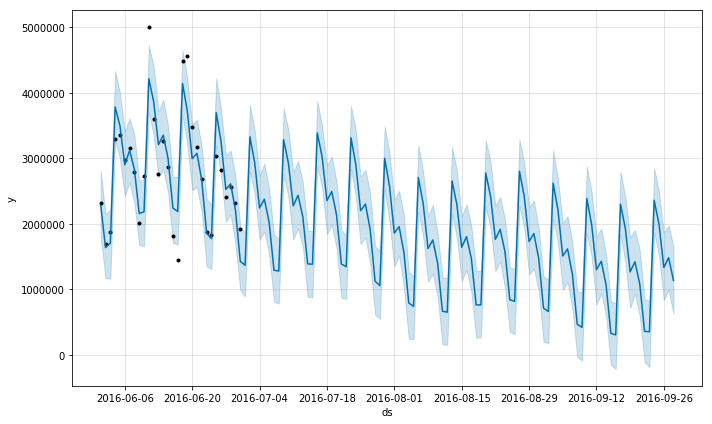

In [4]:
model = Prophet(n_changepoints=23, yearly_seasonality=True, daily_seasonality=True)  
model.fit(df_jun)
future = model.make_future_dataframe(periods = 90 , freq = "d")
forecast = model.predict(future)

predict_30 = forecast[['ds', 'yhat']].merge(df_jun, on='ds', how='left')
predict_30 = round(predict_30,2)
predict_30.columns = ['ds', 'yhat_30_dias', 'y']

# plot
model.plot(forecast);

### Previsão baseada em todo dataset:

In [5]:
#Separando os últimos 15 dias da série para teste do modelo
df.columns = ['ds', 'y']
train = df.loc[df.ds <= "2016-06-15"]
test = df.loc[df.ds > "2016-06-15"]

#### Treino e teste do Modelo:

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Erro médio absoluto %:  18.54 



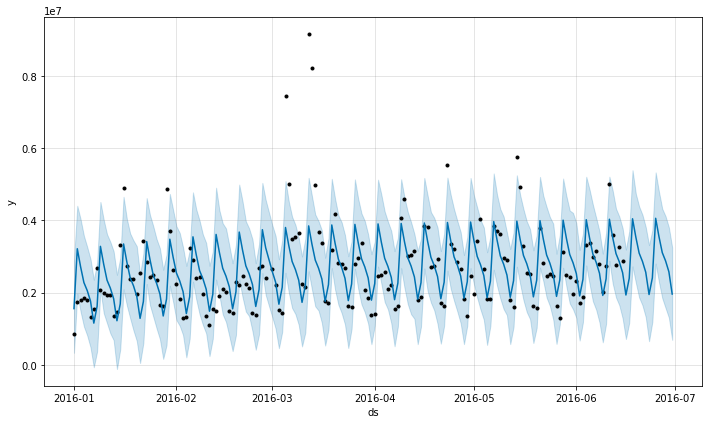

In [6]:
# cria o modelo
model = Prophet(daily_seasonality=True) 
model.fit(train)
future = model.make_future_dataframe(periods =15 , freq = "d")
forecast = model.predict(future)

# plot dos dados reais e das previsões
model.plot(forecast);

# erro médio absoluto do modelo em %
MAPE_S = mean_absolute_percentage_error(y_true = test['y'], y_pred = forecast['yhat'].tail(15))
print('Erro médio absoluto %: ', round(MAPE_S, 2),'\n')

#### Aplicação do modelo:

In [7]:
model = Prophet(daily_seasonality=True) 
model.fit(df)

future = model.make_future_dataframe(periods =90 , freq = "d")
forecast = model.predict(future)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [8]:
predict = forecast[['ds', 'yhat']].merge(predict_30[['ds', 'yhat_30_dias']], on='ds', how='left')
predict = predict.merge(df, on='ds', how='left')
predict = round(predict,2)

In [9]:
predict.to_csv('predict_hotmart.csv', header=True, index=False, encoding='UTF-8', decimal=',')